# Toy Problem Demo

## Scope

Overview of Benchq:
- inputs and outputs
- components:
  - Transpilation (pyliqtr)
  - Jabalizer/ICM
  - Min code distance finding
  - Substrate scheduling


Wait a little for TA 1 and TA 1.5

### Goal: Introduction to Benchq Tool for Resource Estimation

## Agenda
- Quick overview of Benchq usage.
- What is a circuit graph? How do we produce them?
- How do circuit graphs help get resource estimates?
- Look at some pretty plots
  - Preparing a GHZ state
  - The fully connected graph

## Introduction to Graph Estimators

Let's go through a gory example of what benchq is doing for the case of a graph resource estimator.

First we need to import some things and install a python environment in your python installation. This might take a minute.

Running this line will install julia to your python installation. See README for details.

In [45]:
%matplotlib inline
from qiskit import QuantumCircuit
import networkx as nx

from benchq.compilation import get_algorithmic_graph_from_Jabalizer, pyliqtr_transpile_to_clifford_t
from benchq.resource_estimators.graph_estimators import (
    GraphResourceEstimator,
)

In [46]:
from benchq.quantum_hardware_modeling import BASIC_SC_ARCHITECTURE_MODEL

demo_circuit = QuantumCircuit.from_qasm_file("data/single_rotation.qasm")
architecture_model = BASIC_SC_ARCHITECTURE_MODEL

Next, transpile into Clifford + T.

In [43]:
clifford_t_circuit = pyliqtr_transpile_to_clifford_t(
    demo_circuit, circuit_precision=1e-6
)
print(clifford_t_circuit)

Circuit(operations=[H(0), S†(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0)], n_qubits=4)


Transform circuit into graph.

In [7]:
circuit_graph = get_algorithmic_graph_from_Jabalizer(clifford_t_circuit)

update_tableau: 	current_inverse_tableau:   0.000047 seconds (3 allocations: 72 bytes)
	inverse:   0.000748 seconds (4 allocations: 72 bytes)
	update stabilizers: 
	66:	1.424s, elapsed time: 0.02 min
  1.487114 seconds (1.33 M allocations: 86.719 MiB, 2.84% gc time, 90.70% compilation time)
  1.555618 seconds (1.34 M allocations: 87.759 MiB, 2.72% gc time, 90.99% compilation time)
	sort!:   0.000071 seconds (1 allocation: 576 bytes)
	Make X-block upper triangular:   0.000014 seconds (1 allocation: 144 bytes)
	Make diagonal:   0.000008 seconds
	Phase correction and checks:   0.000002 seconds (1 allocation: 672 bytes)
	Check symmetry:   0.000012 seconds


With this use this graph to make resource estimates.

In [47]:
from benchq.resource_estimators.graph_estimators import GraphResourceEstimator
from benchq.algorithms.data_structures import (
    AlgorithmImplementation,
    ErrorBudget,
    GraphPartition,
)
from benchq.problem_embeddings.quantum_program import QuantumProgram

# only allow a failure to occur 1% of the time
budget = ErrorBudget.from_even_split(1e-2)
program = GraphPartition(
    QuantumProgram.from_circuit(clifford_t_circuit), [circuit_graph]
)
implementation = AlgorithmImplementation(program, budget, 1)
estimator = GraphResourceEstimator(architecture_model)

resource_estimates = estimator.estimate(implementation)
print(resource_estimates)

getting max graph degree
starting substrate scheduler
substrate scheduler took 0.012549877166748047 seconds
ResourceInfo(code_distance=15, logical_error_rate=0.0014768016621208176, n_logical_qubits=27, n_physical_qubits=67600, total_time_in_seconds=0.00633, decoder_info=None, magic_state_factory_name='(15-to-1)^6_15,5,5 x (20-to-4)_23,11,13', routing_to_measurement_volume_ratio=0.14786729857819905, extra=GraphData(max_graph_degree=27, n_nodes=3206, n_t_gates=62, n_rotation_gates=0, n_measurement_steps=104), hardware_resource_info=None)


### Summary

#### Minimal Inputs:
- Circuit
- Archetecture Model

#### Outputs:
- Number of physical qubits
- Computation time
- number of measurement steps (will be important later on!)

### Pipelines

#### Example usage

Typically, one would use a pipeline to combine all these steps into one command that benchq can follow.

Here we use one of the pre-configured pipelines called `get_precise_graph_estimate`.

In [26]:
from benchq.resource_estimators.default_estimators import (
    get_precise_graph_estimate,
)
from benchq.conversions import import_circuit

# only allow a failure to occur 1% of the time
budget = ErrorBudget.from_even_split(1e-2)
implementation = AlgorithmImplementation.from_circuit(demo_circuit, budget, 1)
resource_estimate = get_precise_graph_estimate(implementation, architecture_model)

print(resource_estimate)

Transpiling to native gates...
Transpiled in 0.00019979476928710938 seconds.
Creating big graph from subcircuits...
getting networkx graph from vertices
time:  0.0003001689910888672
getting max graph degree
get_graph_state_data:	starting substrate scheduler
substrate scheduler took 0.0001990795135498047 seconds
Memory for data structures allocated
100% (64) completed in       0.0s
  0.000582 seconds (2.33 k allocations: 102.625 KiB)
ResourceInfo(code_distance=14, logical_error_rate=0.0013524576608630586, n_logical_qubits=18, n_physical_qubits=57412, total_time_in_seconds=0.0024648, decoder_info=None, magic_state_factory_name='(15-to-1)^6_15,5,5 x (20-to-4)_23,11,13', routing_to_measurement_volume_ratio=0.08860759493670886, extra=GraphData(max_graph_degree=18, n_nodes=26, n_t_gates=26, n_rotation_gates=0, n_measurement_steps=26), hardware_resource_info=None)


#### Default Pipelines
Benchq offers 5 default pipelines:

1. `get_precise_graph_estimate` - This pipeline uses the most accurate methods for estimating the resources required to run a circuit on a given architecture. It is also the slowest.
2. `get_fast_graph_estimate` - This pipeline uses faster methods for estimating the resources required to run a circuit on a given architecture. It is also less accurate.
3. `get_precise_extrapolation_estimate` - This pipeline uses the most accurate methods for estimating the resources required to get part of the graph. It will then extrapolate out to the size of the full graph.
4. `get_fast_extrapolation_estimate` - This pipeline uses the fastest methods for estimating the resources required to get part of the graph. It will then extrapolate out to the size of the full graph.
5. `get_footprint_estimate` - This pipeline is the fastest estimate, but is also the least accurate. It counts the number of T gates in the circuit and gets a space optimized estimate from that.

They can be imported with the following command:

```python
import benchq.resource_estimators.default_estimators import <pipeline name>
```

And run with the same inputs as above.

## What is a a Circuit Graph?

In [10]:
this_circuit_graph = get_algorithmic_graph_from_Jabalizer(clifford_t_circuit)

update_tableau: 	current_inverse_tableau:   0.000011 seconds (3 allocations: 72 bytes)
	inverse:   0.000566 seconds (4 allocations: 72 bytes)
	update stabilizers: 
	66:	0.002s, elapsed time: 0.0 min
  0.002034 seconds (4.78 k allocations: 183.203 KiB)
  0.002976 seconds (4.86 k allocations: 188.289 KiB)
	sort!:   0.000073 seconds (1 allocation: 576 bytes)
	Make X-block upper triangular:   0.000012 seconds (1 allocation: 144 bytes)
	Make diagonal:   0.000011 seconds
	Phase correction and checks:   0.000003 seconds (1 allocation: 672 bytes)
	Check symmetry:   0.000010 seconds


### What does this do?

Recall that our circuit is in clifford + T form

- Replaces T gates with magic measurements and ancilla
- Use stabilizer simulator efficiently to push single qubit cliffords to one side
- Now we have a circuit of the form Initialization, CNOT, Measurement (ICM form)

In [42]:
print(clifford_t_circuit)

Circuit(operations=[H(0), S†(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0)], n_qubits=4)


In [48]:
import data.get_icm as icm

circuit_after_icm = icm.get_icm(clifford_t_circuit)
print(circuit_after_icm)

Circuit(operations=[H(0), S†(0), H(0), S(0), CNOT(0,4), H(4), S(4), CNOT(4,5), H(5), CNOT(5,6), H(6), CNOT(6,7), H(7), S(7), CNOT(7,8), H(8), CNOT(8,9), H(9), CNOT(9,10), H(10), CNOT(10,11), H(11), S(11), CNOT(11,12), H(12), S(12), CNOT(12,13), H(13), CNOT(13,14), H(14), CNOT(14,15), H(15), S(15), CNOT(15,16), H(16), CNOT(16,17), H(17), CNOT(17,18), H(18), CNOT(18,19), H(19), CNOT(19,20), H(20), S(20), CNOT(20,21), H(21), CNOT(21,22), H(22), S(22), CNOT(22,23), H(23), S(23), CNOT(23,24), H(24), CNOT(24,25), H(25), S(25), CNOT(25,26), H(26), CNOT(26,27), H(27), CNOT(27,28), H(28), CNOT(28,29), H(29), CNOT(29,30), H(30), CNOT(30,31), H(31), CNOT(31,32), H(32), S(32), CNOT(32,33), H(33), S(33), CNOT(33,34), H(34), S(34), CNOT(34,35), H(35), S(35), CNOT(35,36), H(36), CNOT(36,37), H(37), CNOT(37,38), H(38), CNOT(38,39), H(39), S(39), CNOT(39,40), H(40), S(40), CNOT(40,41), H(41), CNOT(41,42), H(42), CNOT(42,43), H(43), CNOT(43,44), H(44), S(44), CNOT(44,45), H(45), S(45), CNOT(45,46), H(46

The middle CNOTS are the interesting part:

- The CNOTS make a graph state
- Use stabilizer simulator to find graph state (Jabalizer)
- Return graph state as circuit graph

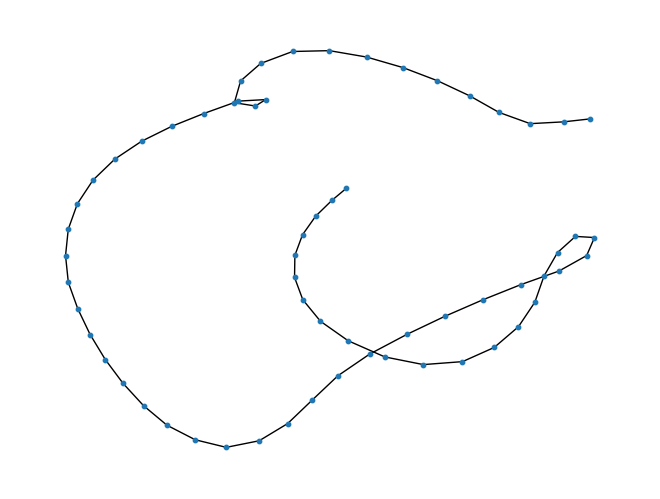

In [13]:
nx.draw(circuit_graph, node_size=10)

Here we see a simple chain graph because our circuit structure simpy passes the qubits down the line generated by decomposing to clifford + T.

### Summary

Circuit graphs are generated from the icm form of a circuit.

They are a representation of the graph state that is generated by the circuit.

## Getting Resource Estimates from Circuit Graphs

Rather than keep the whole graph, we extract the information we need to get resource estimates.

We store this in a `GraphData` object.

Let's make a `GraphData` object from our demo circuit.

In [49]:
from benchq.algorithms.data_structures import GraphPartition

# we have to wrap `circuit_graph` in a `GraphPartition` object,
# but you can ignore that as it is usually done internally
graph_partition = GraphPartition(program, [circuit_graph])

graph_data = estimator._get_graph_data_for_single_graph(graph_partition)
print(graph_data)

getting max graph degree
starting substrate scheduler
substrate scheduler took 0.011377811431884766 seconds
GraphData(max_graph_degree=27, n_nodes=3206, n_t_gates=62, n_rotation_gates=0, n_measurement_steps=104)


As you can see, the graph data involves some data that comes from how the graph was made including `n_t_gates` and `n_rotation_gates`.

`n_measurement_steps` is the number of measurement steps required to prepare that graph_state. It is used to calculate the time required to prepare the graph state.

Next, let's use `graph_data`` to get some resource estimates.

In [50]:
from benchq.magic_state_distillation.litinski_factories import (
    iter_litinski_factories,
)

# One of Litinski's magic state distillation factories. A small one should be just fine for this instance
magic_state_factory = iter_litinski_factories(architecture_model)[0]

logical_qubit_count = len(circuit_graph)

n_total_t_gates = estimator.get_n_total_t_gates(
    graph_data.n_t_gates,
    graph_data.n_rotation_gates,
    budget.transpilation_failure_tolerance,
)

distance = estimator._minimize_code_distance(
    n_total_t_gates,
    graph_data,
    architecture_model.physical_qubit_error_rate,  # physical error
    magic_state_factory,
)
physical_qubit_count = estimator._get_n_physical_qubits(
    graph_data, distance, magic_state_factory
)
total_time = estimator._get_time_per_circuit_in_seconds(
    graph_data, distance, n_total_t_gates, magic_state_factory
)


print(f"distance: {distance}")
print(f"physical qubit count: {physical_qubit_count}")
print(f"total time: {total_time}")

distance: 15
physical qubit count: 28920
total time: 0.0030787200000000005


And there you go! We have some resource estimates.

Don't worry  if the estimates are a little high, that's just because we didn't choose a smaller magic state factory for this calculation.

### How to make Circuit Graph State?

Since graph state is a stabilizer state, we measure stabilizers to generate it!

We could measure all the stabilizers to get the graph.

Measurements are expensive!! So how optimize?

### Substrate Scheduler

Tells us how to measure and which can be measured simultaneously.

In [51]:
from benchq.resource_estimators.graph_estimators import substrate_scheduler

compiler = substrate_scheduler(circuit_graph, "fast")
formatted_measurement_steps = [
    [node[0] for node in step] for step in compiler.measurement_steps
]

print(formatted_measurement_steps)

starting substrate scheduler
substrate scheduler took 0.13897085189819336 seconds
[[518, 2814, 2907, 3003, 3103], [2724, 2815, 2908, 3004, 3104], [2000, 2314, 2391, 2470, 2551, 2636, 2725, 2816, 2909, 3005, 3105], [2240, 2315, 2392, 2471, 2552, 2637, 2726, 2817, 2910, 3006, 3106], [68, 79, 92, 106, 117, 129, 141, 153, 164, 177, 189, 202, 213, 226, 240, 250, 259, 273, 285, 296, 308, 322, 333, 346, 357, 369, 381, 393, 405, 416, 429, 440, 453, 466, 477, 516, 535, 550, 565, 580, 595, 610, 625, 640, 666, 688, 710, 732, 754, 776, 800, 825, 850, 875, 902, 931, 960, 989, 1018, 1051, 1085, 1120, 1155, 1190, 1224, 1260, 1300, 1342, 1384, 1431, 1477, 1525, 1575, 1625, 1677, 1731, 1787, 1845, 1905, 1967, 2032, 2099, 2168, 2241, 2316, 2393, 2472, 2553, 2638, 2727, 2818, 2911, 3007, 3107], [498, 1301, 1343, 1385, 1432, 1478, 1526, 1576, 1626, 1678, 1732, 1788, 1846, 1906, 1968, 2033, 2100, 2169, 2242, 2317, 2394, 2473, 2554, 2639, 2728, 2819, 2912, 3008, 3108], [7, 17, 28, 37, 48, 58, 70, 82, 93, 10

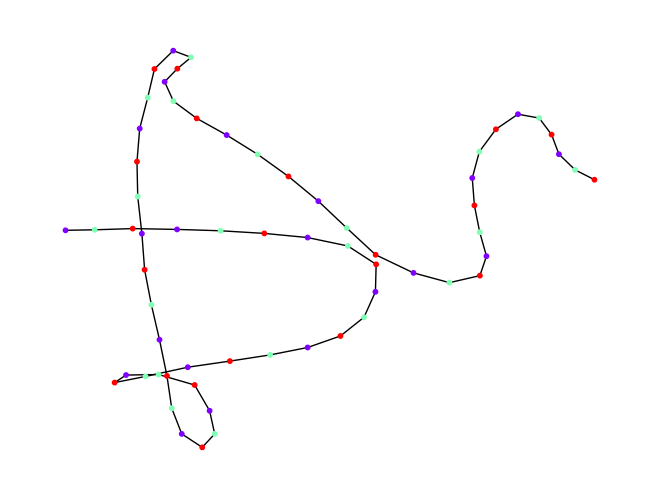

In [22]:
from benchq.visualization_tools import plot_graph_state_with_measurement_steps

plot_graph_state_with_measurement_steps(
    compiler.input_graph, compiler.measurement_steps
)

### Problem! Graph can get too big to handle!

#### Solution! Use subcircuits.

Quantum Algorithms are made up of repeated components.

Estimate resources for each component & multiply by the number of times it was used.

Will create a higher estimate.

More on this later!

## FINALLY! Pretty Graph Time!

Let's look at the graphs of circuits to examine measurement steps!

starting substrate scheduler
substrate scheduler took 7.510185241699219e-05 seconds
update_tableau: 	current_inverse_tableau:   0.000027 seconds (3 allocations: 72 bytes)
	inverse:   0.000053 seconds (4 allocations: 72 bytes)
	update stabilizers: 
	4:	0.0s, elapsed time: 0.0 min
  0.000534 seconds (312 allocations: 12.547 KiB)
  0.001515 seconds (392 allocations: 17.281 KiB)
	sort!:   0.000001 seconds
	Make X-block upper triangular:   0.000002 seconds (1 allocation: 144 bytes)
	Make diagonal:   0.000002 seconds
	Phase correction and checks:   0.000001 seconds
	Check symmetry:   0.000001 seconds


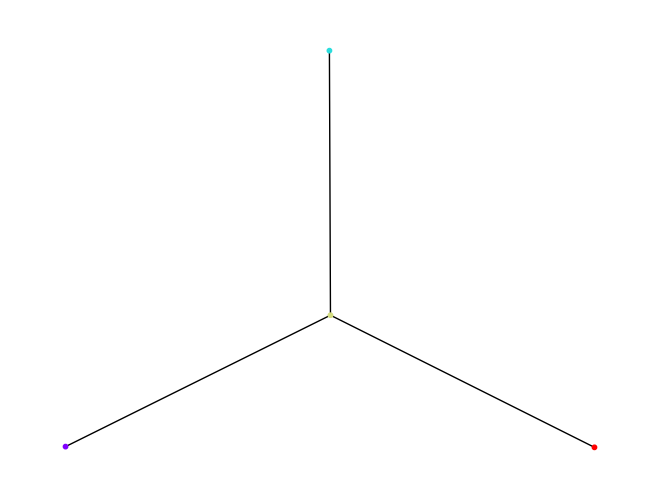

In [23]:
circuit = QuantumCircuit.from_qasm_file("data/ghz_circuit.qasm")

clifford_t_circuit = pyliqtr_transpile_to_clifford_t(circuit, circuit_precision=1e-10)
circuit_graph = get_algorithmic_graph_from_Jabalizer(clifford_t_circuit)
compiler = substrate_scheduler(circuit_graph, "fast")

plot_graph_state_with_measurement_steps(
    compiler.input_graph, compiler.measurement_steps
)

update_tableau: 	current_inverse_tableau:   0.002491 seconds (3 allocations: 72 bytes)
	inverse:   0.283423 seconds (4 allocations: 72 bytes)
	update stabilizers: 
	3208:	0.19s, elapsed time: 0.0 min
  0.190625 seconds (231.00 k allocations: 11.141 MiB)
  0.476994 seconds (231.09 k allocations: 11.146 MiB)
	sort!:   0.274480 seconds (2 allocations: 25.109 KiB)
	Make X-block upper triangular:   0.036588 seconds (1 allocation: 144 bytes)
	Make diagonal:   0.023012 seconds
	Phase correction and checks:   0.000225 seconds (4 allocations: 43.094 KiB)
	Check symmetry:   0.041304 seconds
starting substrate scheduler
substrate scheduler took 0.00705409049987793 seconds


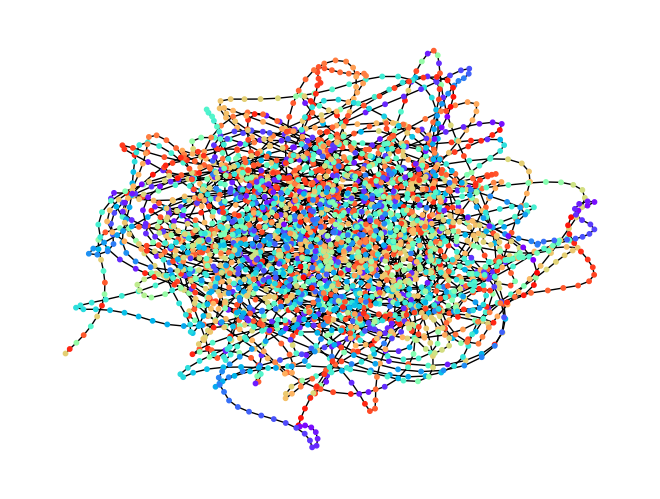

In [24]:
circuit = QuantumCircuit.from_qasm_file("data/h_chain_circuit.qasm")


clifford_t_circuit = pyliqtr_transpile_to_clifford_t(circuit, circuit_precision=1e-10)
circuit_graph = get_algorithmic_graph_from_Jabalizer(clifford_t_circuit)
compiler = substrate_scheduler(circuit_graph, "fast")

plot_graph_state_with_measurement_steps(
    compiler.input_graph, compiler.measurement_steps
)

## Closing Statements

### What did we learn?


#### Inputs
- Circuit
- Architecture model
#### Outputs
- Number of physical qubits
- Computation time
- Number of measurement steps



#### Components:
- Transpilation (pyliqtr)
  - Bring to Clifford + T
- Jabalizer/ICM
  - Easy way to represent circuit
- Min code distance finding
  - Number of physical qubits
  - Computation time
- Substrate scheduling
  - number of measurement steps

## What's Next?

- How to get resource estimate for large algorithms? (QuantumPrograms)
- Compare to other resource estimators.
- Try this notebook out for yourself!!